In [ ]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.models import ColumnDataSource
%matplotlib inline

imdb = pd.read_csv('movies.csv')

DATA CLEANUP

In [ ]:
#Set objects to strings
imdb = imdb.astype({'name': 'string', 
                    'rating':'string',
                    'genre':'string', 
                    'released':'string',
                    'director':'string',
                    'writer':'string',
                    'star':'string',
                    'country':'string',
                    'company':'string',})


#Separate release date information
imdb[['released_date','released_country']] = imdb['released'].str.slice(stop=-1).str.split(" \(",n=1,expand = True)
imdb.drop('released',axis=1)
imdb['released_date'] = pd.to_datetime(imdb['released_date'])#,format="%B %d, %Y")

#Drop NaN values 
imdb = imdb.dropna(subset=['gross', 'budget', 'score', 'released_date'])

#Turn into datetime
imdb['released_month'] = imdb['released_date'].dt.month
imdb['released_day'] = imdb['released_date'].dt.day
imdb['released_year'] = imdb['released_date'].dt.year

#Add decade column
def decade(i):
    if (i == 1980) or (i <=1989):
        return 1980
    elif (i == 1990) or (i <=1999):
        return 1990
    elif (i == 2000) or (i <=2009):
        return 2000
    elif (i == 2010) or (i <=2019):
        return 2010
    elif (i == 2020) or (i <=2029):
        return 2020
    
imdb['decade'] = imdb['year'].apply(lambda x: decade(x))

#Add profit and profit margin columns
imdb['net'] = imdb['gross'] - imdb['budget']


GET MOVIE RANKING (according to Audience Score)

In [ ]:
movie_scores = imdb[['name','score']]
movie_scores = movie_scores.sort_values('score',ascending=False)
movie_scores['rank']=movie_scores['score'].rank(method='min',ascending=False)
movies = list(movie_scores['name'])

while True:
    x = str(input("Name of Movie: "))
    if x not in movies:
        continue
    else:
        rank = movie_scores[movie_scores['name']==x].get("rank").mean()
        print(x, " ranks (according to Audience Score) at: ",rank)
        break
        
        Avatar

Name of Movie: Avatarr
Name of Movie: Avatar
Avatar  ranks (according to Audience Score) at:  247.0


GET MOVIE RANKING (according to Gross Revenue)

In [ ]:
movie_revenues = imdb[['name','gross']]
movie_revenues = movie_revenues.sort_values('gross',ascending=False)
movie_revenues['rank']=movie_revenues['gross'].rank(method='min',ascending=False)
  
while True:
    x = str(input("Name of Movie: "))
    if x not in movies:
        continue
    else:
        rank = movie_revenues[movie_revenues['name']==x].get("rank").mean()
        print(x, " ranks (according to revenue) at: ",rank)
        break

Name of Movie: Avatar
Avatar  ranks (according to revenue) at:  1.0


AGGREGATE PROFITS AND REVENUE/SPENDING DISITRIBUTION BY GENRE 

In [ ]:
genres = imdb.groupby('genre')
genres_means = (genres[['gross','budget','net']].sum()/1000000000).astype('float32')
genres_df = pd.DataFrame(genres_means)
genres_df['num_movies'] = genres.size()
genres_df['Budget'] = genres['budget'].sum()/-1000000000

source=ColumnDataSource(genres_df)

b = ["Budget"]
g = ["gross"]

tooltips = [("Genre", "@genre"),
            ("Number of Movies", "@num_movies"),
            ("Net Profit (Billions)", "@net")]

p = figure(y_range=source.data['genre'], height=400, width=900, x_range=(-100, 250), title="Mean revenue/budget (in Billions), by genre",
           toolbar_location=None, tooltips=tooltips)

p.hbar_stack(g, y='genre', height=0.9, color="green", source=source,legend_label="Revenues")

p.hbar_stack(b, y='genre', height=0.9, color="orange", source=source,legend_label="Budget")

p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_right"
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p)

TOP 5 DIRECTORS BY REVENUE

In [ ]:
popular_directors = imdb.groupby('director')['gross'].mean()/1000000
popular_directors_df = pd.DataFrame(popular_directors.sort_values(ascending=False))
popular_directors_df['num_movies'] = imdb.groupby('director')['name'].count()
#popular_directors_df['director'] = popular_directors_df.index
#popular_directors['Christopher Nolan']
top_5 = popular_directors_df[0:5]
#top_5_director_movies = director_movies.loc[['Roberto Benigni','Tony Kaye','Bob Persichetti','Nadine Labaki','Sergio Leone']]
#top_5_joint = top_5.join(top_5_director_movies)

source = ColumnDataSource(top_5)

tooltips = [("Average Revenue", "@gross"),
            ("Number of movies", "@num_movies")]#,
           #("Movie Name", "@name")]

p = figure(x_range=source.data['director'], plot_height=400, 
           x_axis_label = "Director",
           y_axis_label = "Mean Revenue (Millions of USD)",
           title="Top Directors according to Mean Revenue",tooltips=tooltips)
p.vbar(x='director', top='gross' , width=0.5, color = "cyan", line_color='black',hover_fill_color = 'magenta', source=source)

p.xgrid.grid_line_color = None
#p.y_range.start = 7.5   
#p.y_range.end = 9 

show(p)

REVENUE & BUDGET OVER TIME

In [ ]:
date_group = imdb.groupby('released_year')
metrics = date_group['gross'].mean()/1000000
metrics_df = pd.DataFrame(metrics)
metrics_df['budget'] = date_group['budget'].mean()/1000000
metrics_df

source = ColumnDataSource(metrics_df)

#tooltips = [("Year","@released_year")]

p = figure(width=400, height=400,
           x_axis_label = "Year Released",
           y_axis_label = "(Millions of USD)",
           title="Gross Revenue & Budget Over Time")#,
          #tooltips=tooltips)

p.varea_stack(['budget', 'gross'], x='released_year', color=("orange", "yellow"), legend_label=("Budget", "Revenue"),source=source)

p.legend.location = "top_left"

show(p)

TOP COMPANIES BY NET PROFIT

In [ ]:
this_decade = imdb[(imdb['decade'] == 2010) | (imdb['decade'] == 2020)]
this_decade = this_decade[['name','company','gross','budget']].sort_values('gross',ascending=False)
this_decade['net'] = this_decade['gross']-this_decade['budget'] 
recent_net_profits = this_decade[['name','company','net']]

company = recent_net_profits.groupby(['company']).net.sum().sort_values(ascending=False).head(15).reset_index()


movie_count = recent_net_profits.groupby(['company'])['name'].count()

company = company.join(movie_count, on="company")
company.columns = ['company', 'net','num_movies']

company.loc[15] = ['Average (Top 15 Companies)', company['net'].mean(), company['num_movies'].sum()]
company.loc[16] = ['Average (Of All Companies)', 
                   recent_net_profits.groupby(['company']).net.sum().sort_values(ascending=False).reset_index()['net'].mean(), 
                   movie_count.sum()]

company['net'] = (company['net']/1000000000) 


source=ColumnDataSource(company)

tooltips = [("Company: ", "@company"),
            ("Net Profit: ", "@net"),
            ("Number of Movies: ", "@num_movies")]

p = figure(y_range=source.data['company'], height=250, x_range=(0, 20), title="Top Companies vs Net Profit",
           toolbar_location=None, tooltips=tooltips, y_axis_label = "Top 15 Companies",
           x_axis_label = "Net Profit (Billions of USD)",)

p.hbar(y='company', right='net', height=0.5, color = "red", line_color='black',hover_fill_color = 'blue', source=source)

show(p)

CORRELATION ANALYSIS

0.7403948929894826


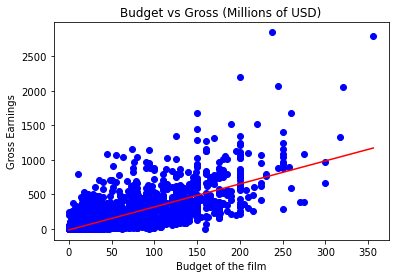

In [ ]:
#BUDGET & REVENUE
x=imdb["budget"]/1000000
y=imdb["gross"]/1000000
plt.scatter(x, y, color="blue")
#sns.regplot(x="budget", y="gross", data=imdb, scatter_kws={"color":"black"}, line_kws={"color":"purple"})
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
plt.title("Budget vs Gross (Millions of USD)")
plt.xlabel("Budget of the film")
plt.ylabel("Gross Earnings")

correlation = y.corr(x)
print(correlation) 

plt.show()

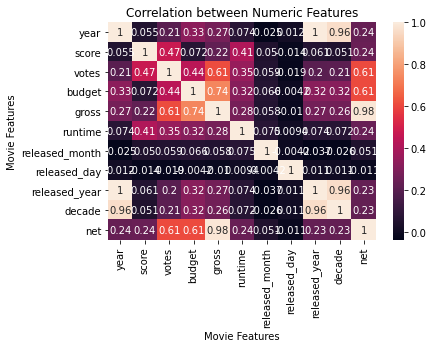

In [ ]:
#CORRELATION MATRIX
import seaborn as sns
imdb.corr(method="pearson")

corr_matrix= imdb.corr(method="pearson")
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation between Numeric Features")
plt.xlabel("Movie Features")
plt.ylabel("Movie Features")
plt.show()

0.22214336377548086


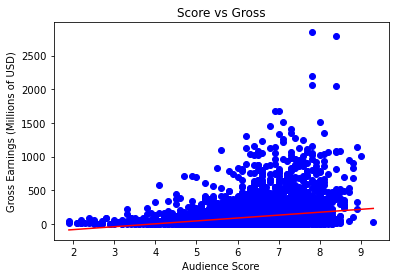

In [ ]:
#AUDIENCE SCORE & REVENUE
x=imdb["score"]
y=imdb["gross"]/1000000
plt.scatter(x, y, color="blue")
#sns.regplot(x="budget", y="gross", data=imdb, scatter_kws={"color":"black"}, line_kws={"color":"purple"})
plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))
         (np.unique(x)), color='red')
plt.title("Score vs Gross")
plt.xlabel("Audience Score")
plt.ylabel("Gross Earnings (Millions of USD)")

correlation = y.corr(x)
print(correlation) 

plt.show()